# DM-34846: correct CompensableImage docstring 

This is to illustrate the behavior of `CompensableImage`, in `ts_wep` `2.4.0`.
It is based on  https://jira.lsstcorp.org/browse/DM-33104

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
import os

## Compensable image

It is used in https://github.com/lsst-ts/ts_wep/blob/7561f2d20b36c051df0cdbb629d102bdcc260da7/python/lsst/ts/wep/cwfs/Algorithm.py#L1187 

and https://github.com/lsst-ts/ts_wep/blob/abd15793e7e0f0484de03661caf4c1783e78a24f/python/lsst/ts/wep/task/DonutStamp.py 

and  https://github.com/lsst-ts/ts_wep/blob/c48e1528145edcc66af4c82e8ff9e068711cae99/python/lsst/ts/wep/WfEstimator.py

while it is defined in  https://github.com/lsst-ts/ts_wep/blob/7561f2d20b36c051df0cdbb629d102bdcc260da7/python/lsst/ts/wep/cwfs/CompensableImage.py


This function creates an array of correct dimension, and makes compensable image for `comcam`:

In [2]:
def get_comp_image(boundaryT=1,
                   optical_model="offAxis",
                   maskScalingFactorLocal =1,
                   field_xy = (1.1,1.2),
                   donut_stamp_size = 160,
                   inst_name='comcam') :
    ''' Get compensable image for field location 
    
    Parameters:
    -----------
    boundaryT : int
        Extended boundary in pixel. It defines how far the computation mask
        extends beyond the pupil mask. And, in fft, it is also the width of
        Neuman boundary where the derivative of the wavefront is set to
        zero.
    optical_model : str
        Optical model. It can be "paraxial", "onAxis", or "offAxis".
    maskScalingFactorLocal : float
        Mask scaling factor (for fast beam) for local correction.
        
    field_xy : tuple or list
            Position of donut on the focal plane in degree (field x, field y).

    '''
    # make fake donut array so no data is needed
    x = np.linspace(-2,2,donut_stamp_size)
    y = np.linspace(-2,2,donut_stamp_size)
    xx, yy = np.meshgrid(x,y)
    z = np.exp(np.cos(5*xx)-np.sin(5*yy))
     
    # initialize compensable image 
    imgExtra = CompensableImage() 

    # this is like setup in WfEstimator()
    config_dir = getConfigDir()
    inst_dir = os.path.join(config_dir, "cwfs", "instData")
    instrument = Instrument(inst_dir)

    camType = getCamType(inst_name)
    defocalDisInMm = getDefocalDisInMm(inst_name)
    instrument.config(
                camType, donut_stamp_size, announcedDefocalDisInMm=defocalDisInMm
            )

    # this is similar to _makeCompensableImage() in donutStamp.py, 
    imgExtra.setImg(
                field_xy,
                DefocalType.Extra,
                image=z
            )
    imgExtra.makeMask(instrument, optical_model, boundaryT, maskScalingFactorLocal)
    
    return imgExtra

Make `compensableImage` with  varying the boundary size to illustrate the point:

In [3]:
imgExtra1 = get_comp_image(boundaryT=1)
imgExtra7 = get_comp_image(boundaryT=7)

Plot `cMask`:

Text(0.5, 1.0, 'cMask, boundaryT=7')

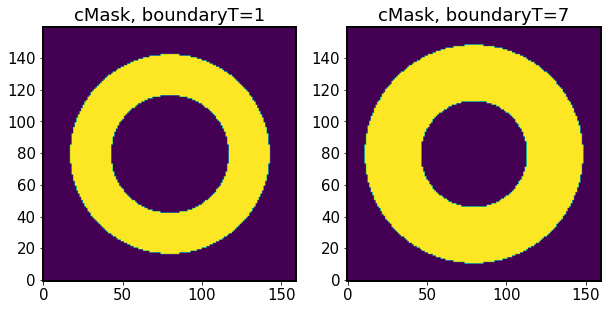

In [7]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(imgExtra1.cMask, origin='lower')
ax[0].set_title('cMask, boundaryT=1')
ax[1].imshow(imgExtra7.cMask, origin='lower')
ax[1].set_title('cMask, boundaryT=7')

`cMask` changes size with varying `boundaryT`, since it stands for "computational mask", i.e. padded version of "pupil mask".

Plot `pMask`:

Text(0.5, 1.0, 'pMask, boundaryT=7')

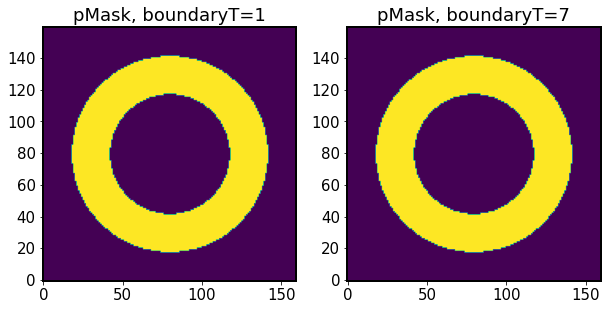

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(imgExtra1.pMask, origin='lower')
ax[0].set_title('pMask, boundaryT=1')
ax[1].imshow(imgExtra7.pMask, origin='lower')
ax[1].set_title('pMask, boundaryT=7')

For different values of `boundaryT` parameter, `pMask`s are identical. This is because `pMask` stands for "pupil mask"

According to the docs , https://github.com/lsst-ts/ts_wep/blob/7561f2d20b36c051df0cdbb629d102bdcc260da7/python/lsst/ts/wep/cwfs/CompensableImage.py#L1464  `boundaryT` parameter  `defines how far the computation mask extends beyond the pupil mask.`. I think that the docstring which says 

      pMask: padded mask for use at the offset planes
      cMask: non-padded mask corresponding to aperture

is incorrect, as `pMask` seems to mean `pupil mask`, and `cMask` for `computation mask`, and the definitions above are opposite to truth (`cMask` is a padded version of `pMask`).
            
    Show that this is indeed the case. Calculate `comensableImage` with two different `boundaryT` values. Plot the mask:
    
(by extension I think that statements later in the same function calling `pMask` the "padded mask" and `cMask` the "non-padded mask corresponding to aperture" are just following the same mistake https://github.com/lsst-ts/ts_wep/blob/7561f2d20b36c051df0cdbb629d102bdcc260da7/python/lsst/ts/wep/cwfs/CompensableImage.py#L1487 ) 